In [1]:
from __future__ import print_function
import numpy as np
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

import matplotlib.pyplot as plt
%matplotlib inline

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
max_features = 20000  # 一共保留多少个不同的词作为特征
maxlen = 100  # 每条数据保留的最多的词数
batch_size = 32  # batch size

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Loading data...
17465344/17464789 [==============================] - 18s 1us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [3]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))  # 嵌入层
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))  # 64 代表的是隐层单元数（输出的维度数），但是因为是双向循环神经网络，所以输出维度为 128
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [4]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,658,945
Trainable params: 2,658,945
Non-trainable params: 0
_________________________________________________________________


In [5]:
class LossHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def plot_loss(self, loss_type='epoch'):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc='upper right')
        plt.show()

history = LossHistory()

In [6]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=[x_test, y_test],
          callbacks=[history])

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 120s 5ms/step - loss: 0.8016 - acc: 0.7057 - val_loss: 0.5689 - val_acc: 0.7758
Epoch 2/15
25000/25000 [==============================] - 116s 5ms/step - loss: 1.0274 - acc: 0.7931 - val_loss: 1.9540 - val_acc: 0.7592
Epoch 3/15
25000/25000 [==============================] - 119s 5ms/step - loss: 1.0527 - acc: 0.8268 - val_loss: 0.9342 - val_acc: 0.7429
Epoch 4/15
25000/25000 [==============================] - 118s 5ms/step - loss: 0.4635 - acc: 0.8402 - val_loss: 0.4537 - val_acc: 0.7882
Epoch 5/15
25000/25000 [==============================] - 116s 5ms/step - loss: 0.7667 - acc: 0.8885 - val_loss: 0.7419 - val_acc: 0.8153
Epoch 6/15
25000/25000 [==============================] - 116s 5ms/step - loss: 0.3647 - acc: 0.9341 - val_loss: 0.6808 - val_acc: 0.8113
Epoch 7/15
25000/25000 [==============================] - 117s 5ms/step - loss: 0.3112 - acc: 0.9454 - val_loss: 

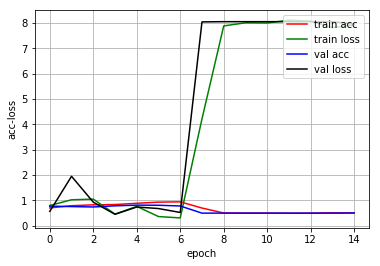

In [7]:
history.plot_loss('epoch')